# Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif,chi2
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,StandardScaler


# import data into pandas dataframe

In [2]:
data = pd.read_csv('stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# drop the id column
data.drop(['id'],axis=1,inplace=True)

# Data Cleaning

In [4]:
# check for null values
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [5]:
# replace null value with the mean of bmi
data['bmi']=data['bmi'].fillna(data['bmi'].mean())

In [6]:
data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [7]:
# check out the columns in the dataset
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [8]:
# check for unique values in each of the categorical column
category = ['gender','hypertension', 'heart_disease','ever_married','work_type', 'Residence_type','smoking_status', 'stroke']

for cat in category:
    x = data[cat].unique()
    print(cat + ':',np.sort(x,axis=None),'\n')

gender: ['Female' 'Male' 'Other'] 

hypertension: [0 1] 

heart_disease: [0 1] 

ever_married: ['No' 'Yes'] 

work_type: ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children'] 

Residence_type: ['Rural' 'Urban'] 

smoking_status: ['Unknown' 'formerly smoked' 'never smoked' 'smokes'] 

stroke: [0 1] 



In [9]:
# convert them into categorical data type

for cats in category:
    data[cats] = pd.Categorical(data[cats])

In [10]:
# check the statistics of the numerical columns
data.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.698018
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.800000
50%,45.000000,91.885000,28.400000
75%,61.000000,114.090000,32.800000
max,82.000000,271.740000,97.600000


Age has an abnormal value 0.08 i have to remove it


In [11]:
# convert age to integer value

data.age = data.age.astype('int64') # this will convert 0.08 to 0.00
# replace 0.00 with NaN

data['age'] = data['age'].replace(0,np.nan)

# drop nan 

data.dropna(axis=0, inplace=True)
# reset the index
data.reset_index(drop=True,inplace=True)


In [12]:
data.describe()

,age,avg_glucose_level,bmi
count,5067.000000,5067.000000,5067.000000
mean,43.582001,106.241593,28.982070
std,22.375297,45.394524,7.661253
min,1.000000,55.120000,10.300000
25%,26.000000,77.285000,23.900000
50%,45.000000,91.890000,28.400000
75%,61.000000,114.125000,32.800000
max,82.000000,271.740000,97.600000


In [13]:
# check categorical columns
data.describe(include='category')

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke
count,5067,5067,5067,5067,5067,5067,5067,5067
unique,3,2,2,2,5,2,4,2
top,Female,0,0,Yes,Private,Urban,never smoked,0
freq,2979,4569,4791,3353,2925,2573,1892,4818


# Exploratory Data Analysis
Categorical Data

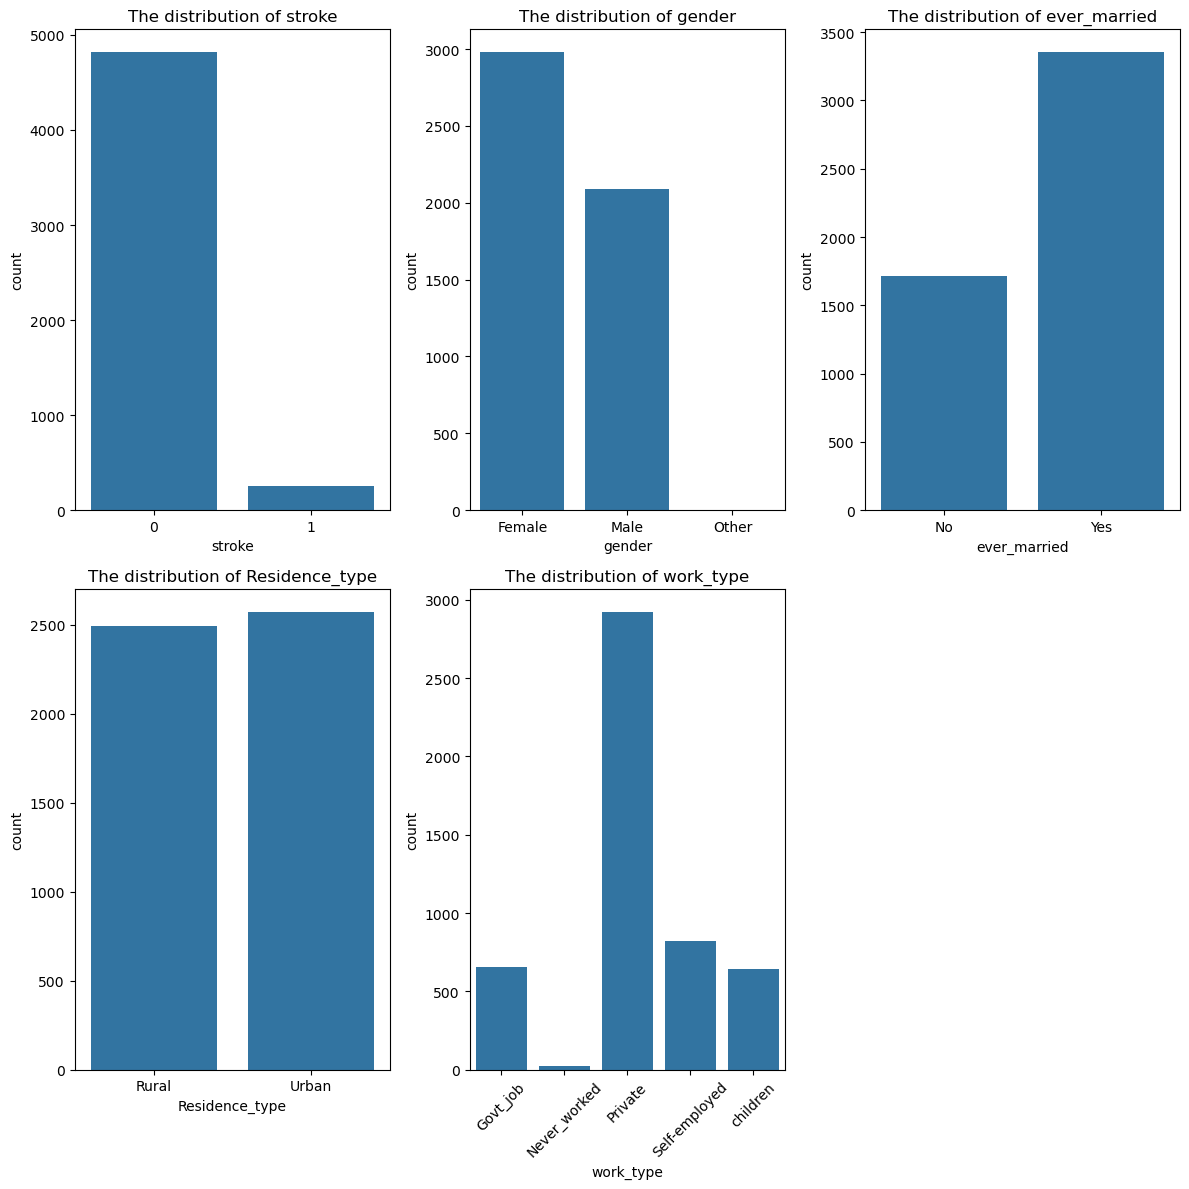

In [14]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']

for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(data,x=cat,)
    plt.title(f'The distribution of {cat}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1. Stroke Distribution shows that the dataset contains more people with stroke than those without stroke this shows that the dataset is imbalanced and can make our model biased.
2. gender distribution shows that we have more female than male in the dataset
3. ever married there are more married people than unmarried people in the dataset
4. residence type distribution shows that there are almost equal number of people living in rural and urban areas
5. the work type distrubtion shows that more people in the dataset work in private organisations

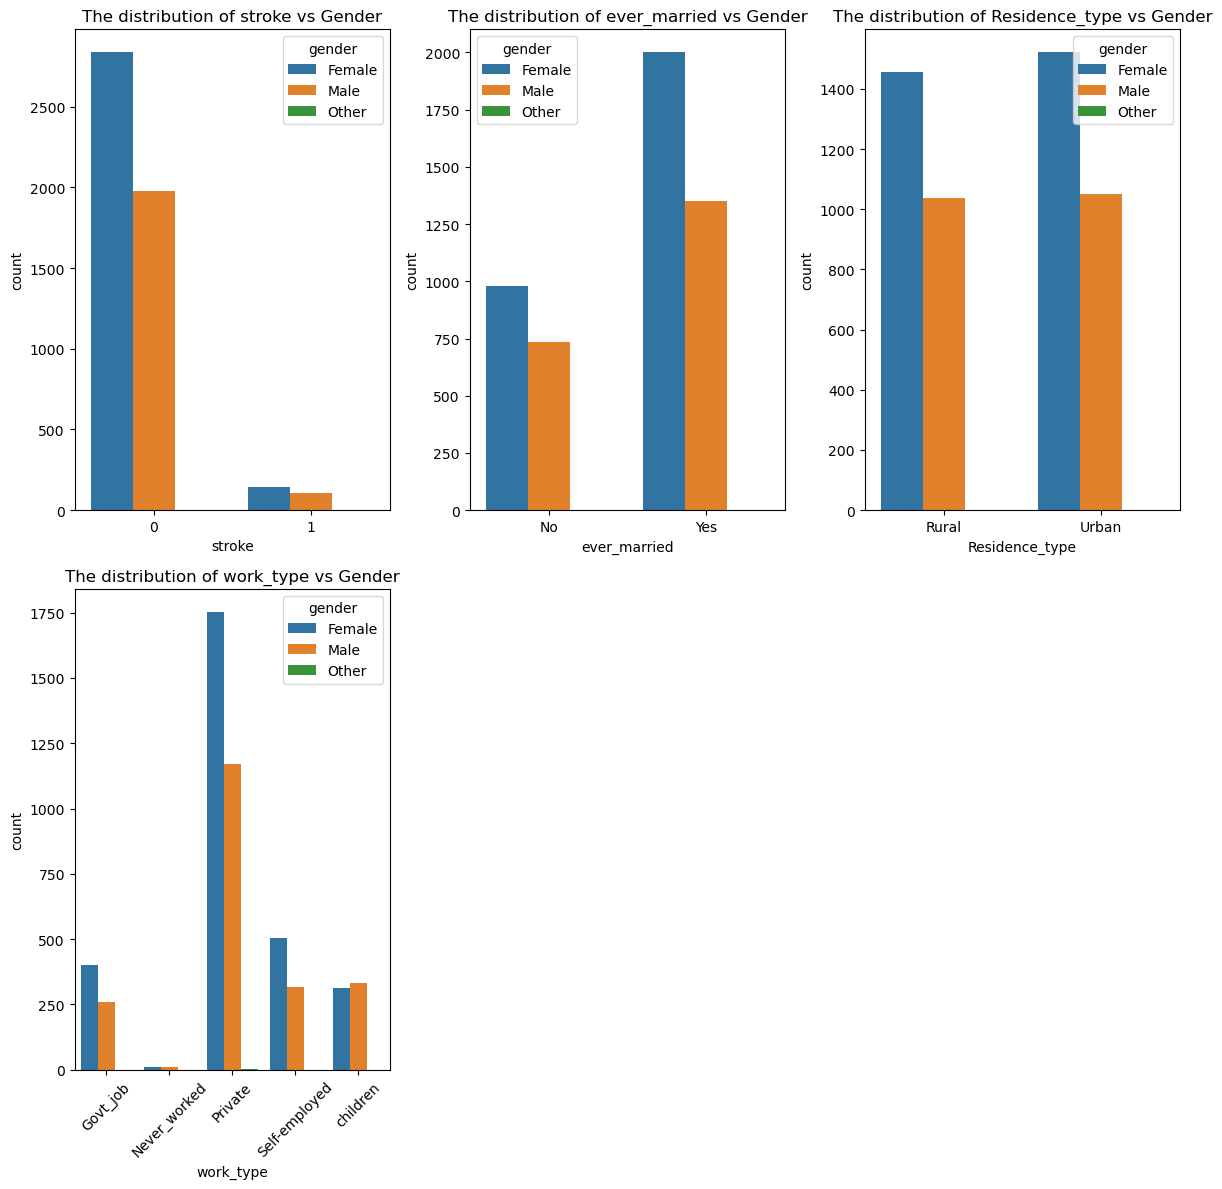

In [15]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(data,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

lets group the age into age groups
1. Adolescence 15-19
2. Young Adult 20-39
3. Adult 40-64
4. middle Age 65-74
5. older 75....


# Adolescence

In [16]:
adolescence = data[(data['age'] <=19)&(data['age']>15)]
adolescence.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
288,Female,17.0,0,0,No,Self-employed,Urban,82.18,23.4,Unknown,0
292,Female,16.0,0,0,No,children,Rural,110.63,19.5,Unknown,0
329,Female,18.0,0,0,No,Private,Rural,111.38,38.4,smokes,0
370,Female,18.0,0,0,No,Private,Urban,80.05,24.2,never smoked,0
393,Female,17.0,0,0,No,Private,Urban,87.52,39.2,never smoked,0


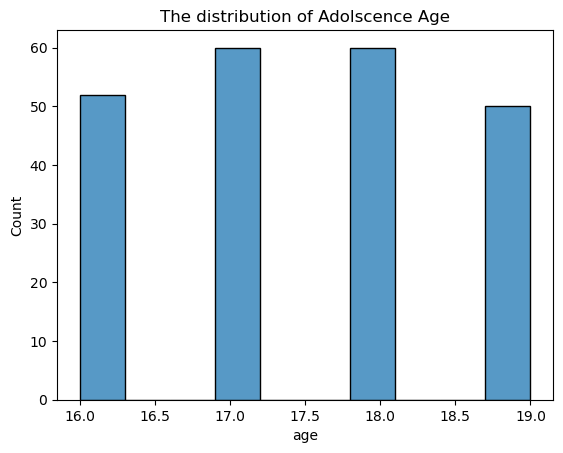

In [17]:
sns.histplot(adolescence,x='age')
plt.title('The distribution of Adolscence Age')
plt.show()

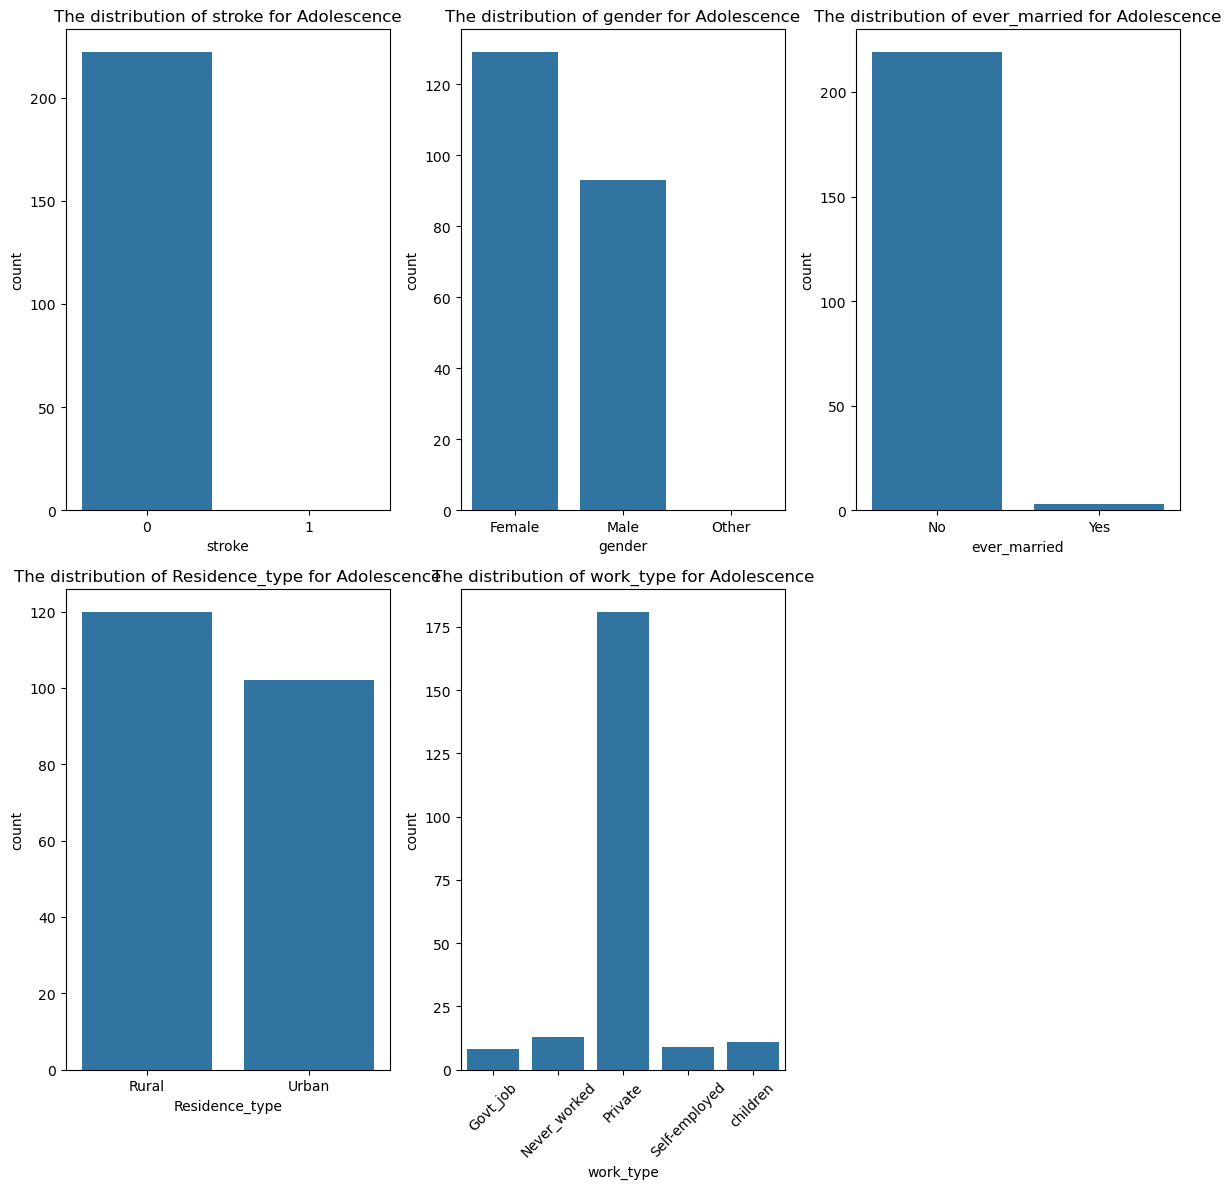

In [18]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(adolescence,x=cat,)
    plt.title(f'The distribution of {cat} for Adolescence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Adolescence dont have stroke according to the dataset
2. most adolesence live in Rural areas
3. most of them work in private establishment

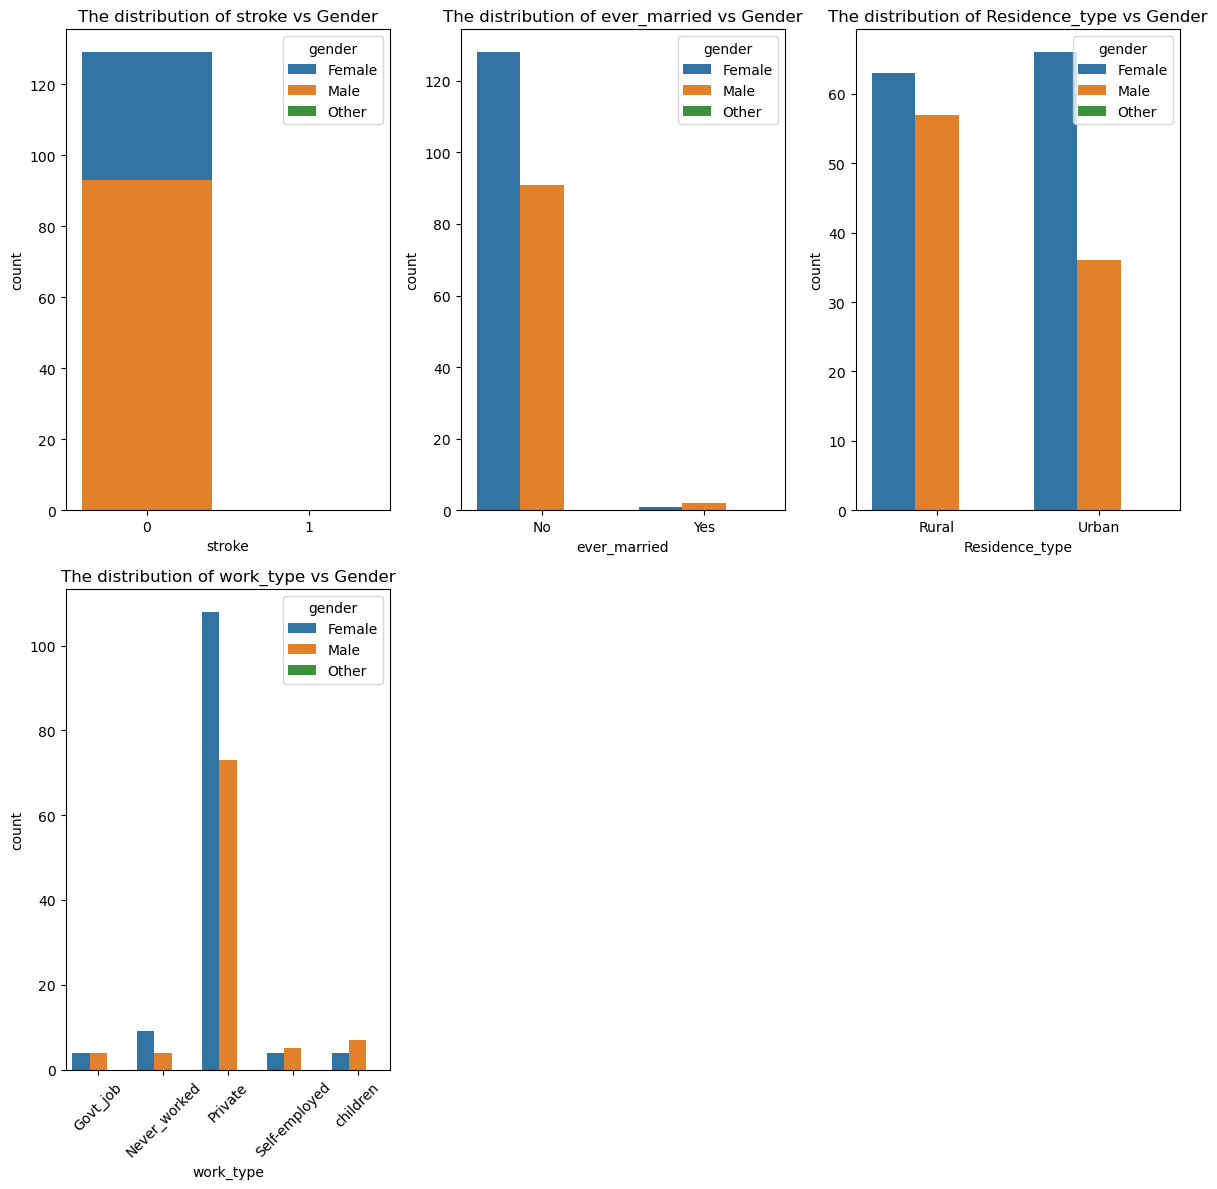

In [19]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(adolescence,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. there are more married female among adolescence than the male
2. there are more female in urban areas than in rural
3. there are more male in rural areas than in urban 

# Young Adult

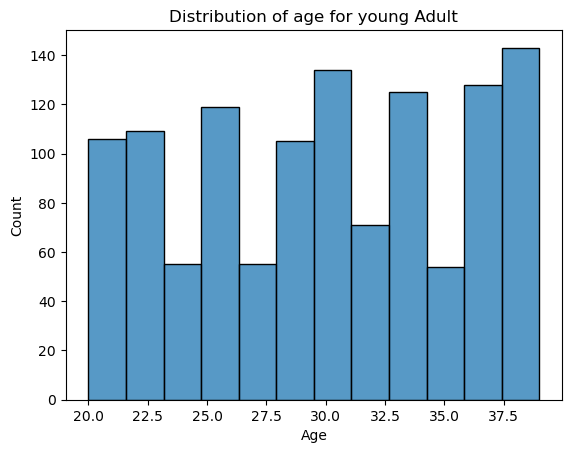

In [21]:
sns.histplot(youngadult, x='age')
plt.title('Distribution of age for young Adult')
plt.xlabel('Age')
plt.show()

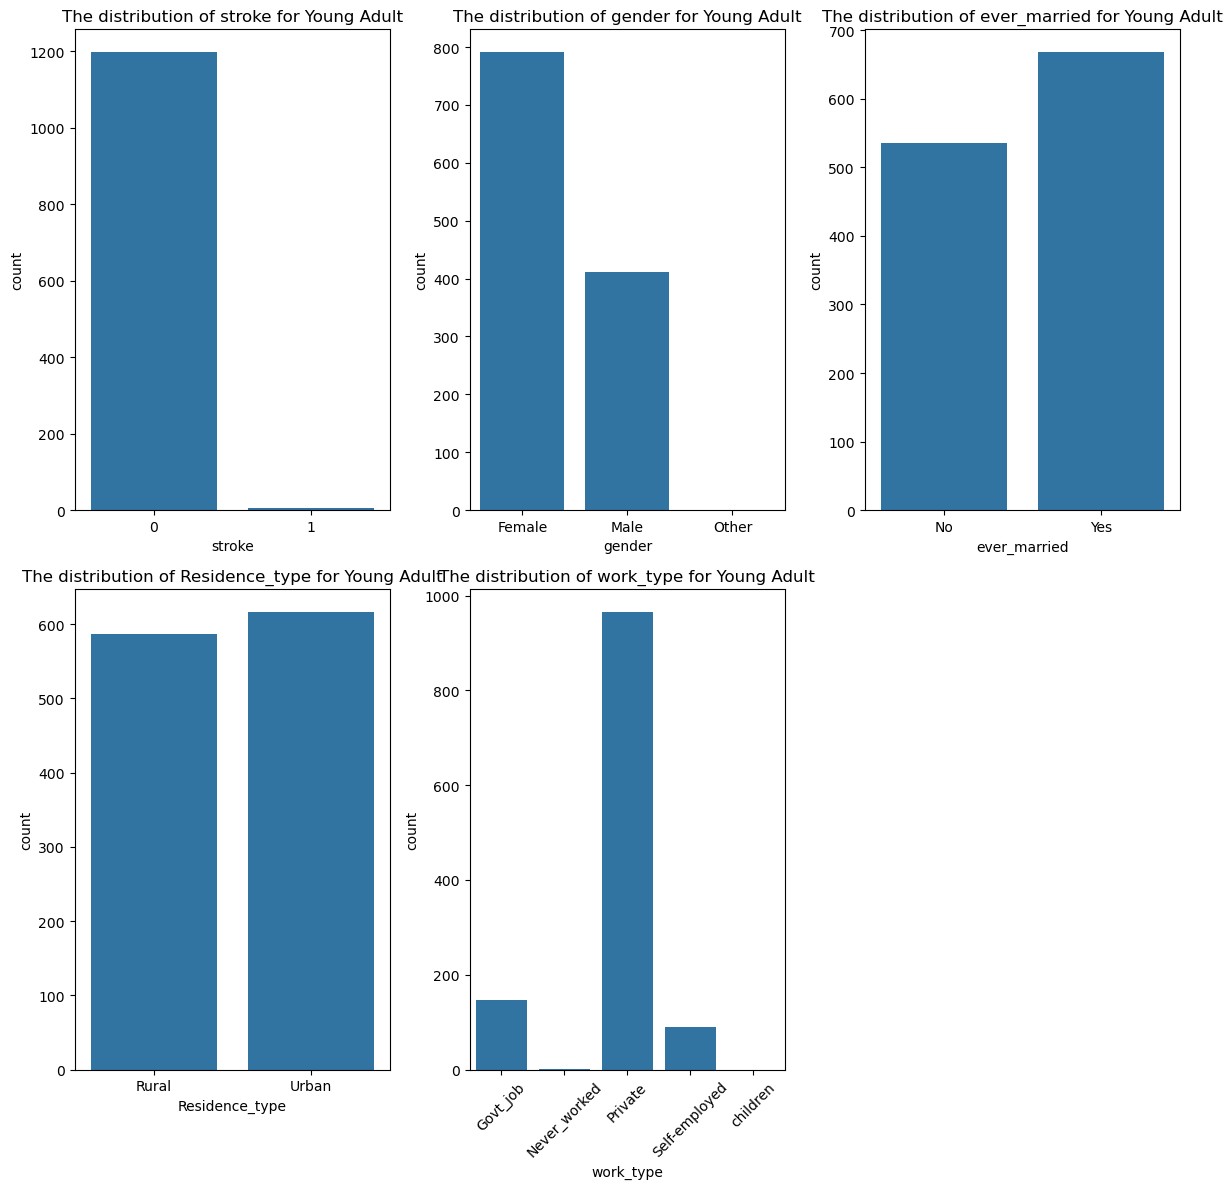

In [22]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(youngadult,x=cat,)
    plt.title(f'The distribution of {cat} for Young Adult')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. there are more married people among the young adults
2. most young adults live in the urban area
3. most engage in private work

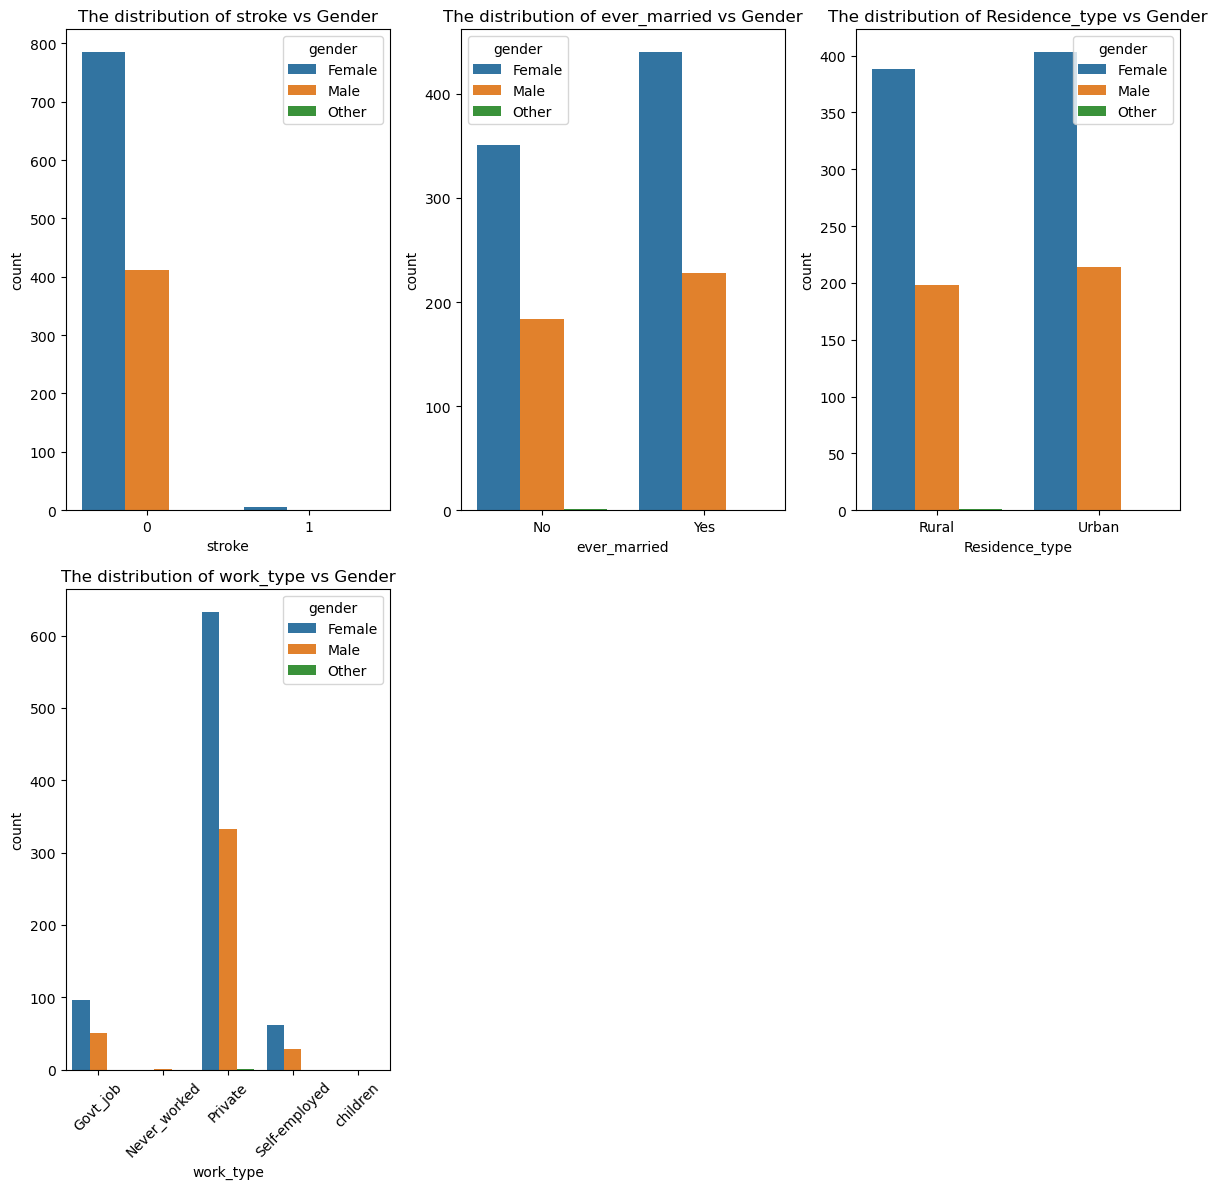

In [23]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(youngadult,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. there is a few number of youn adults with stroke

# Adult

In [24]:
adult = data[(data['age']>=40)&(data['age']<=64)]
adult.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,28.893237,Unknown,1
11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.800000,smokes,1
12,Female,54.0,0,0,Yes,Private,Urban,104.51,27.300000,smokes,1


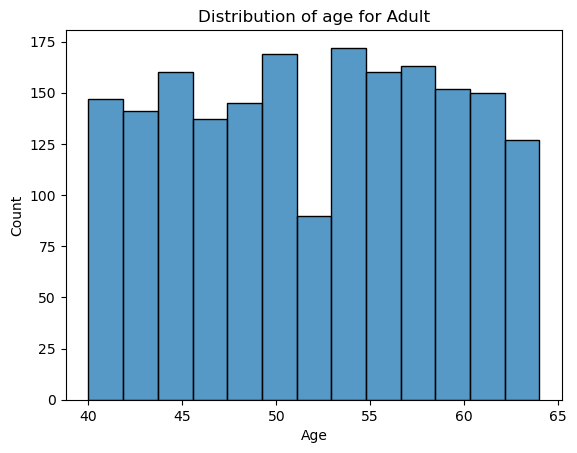

In [25]:
sns.histplot(adult, x='age')
plt.title('Distribution of age for Adult')
plt.xlabel('Age')
plt.show()

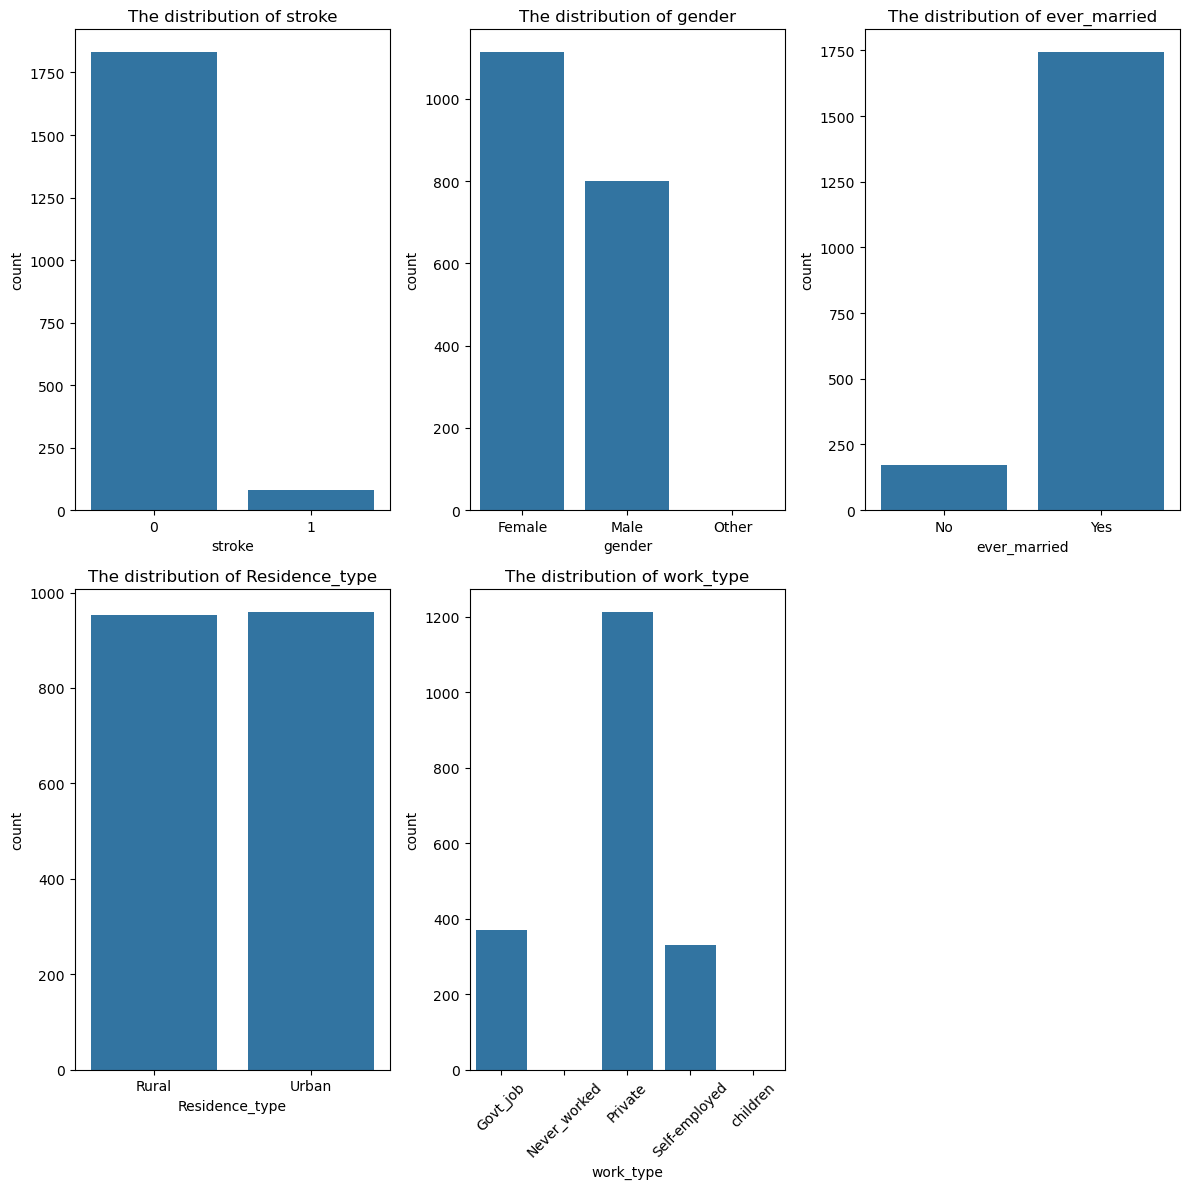

In [26]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']

for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(adult,x=cat,)
    plt.title(f'The distribution of {cat}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

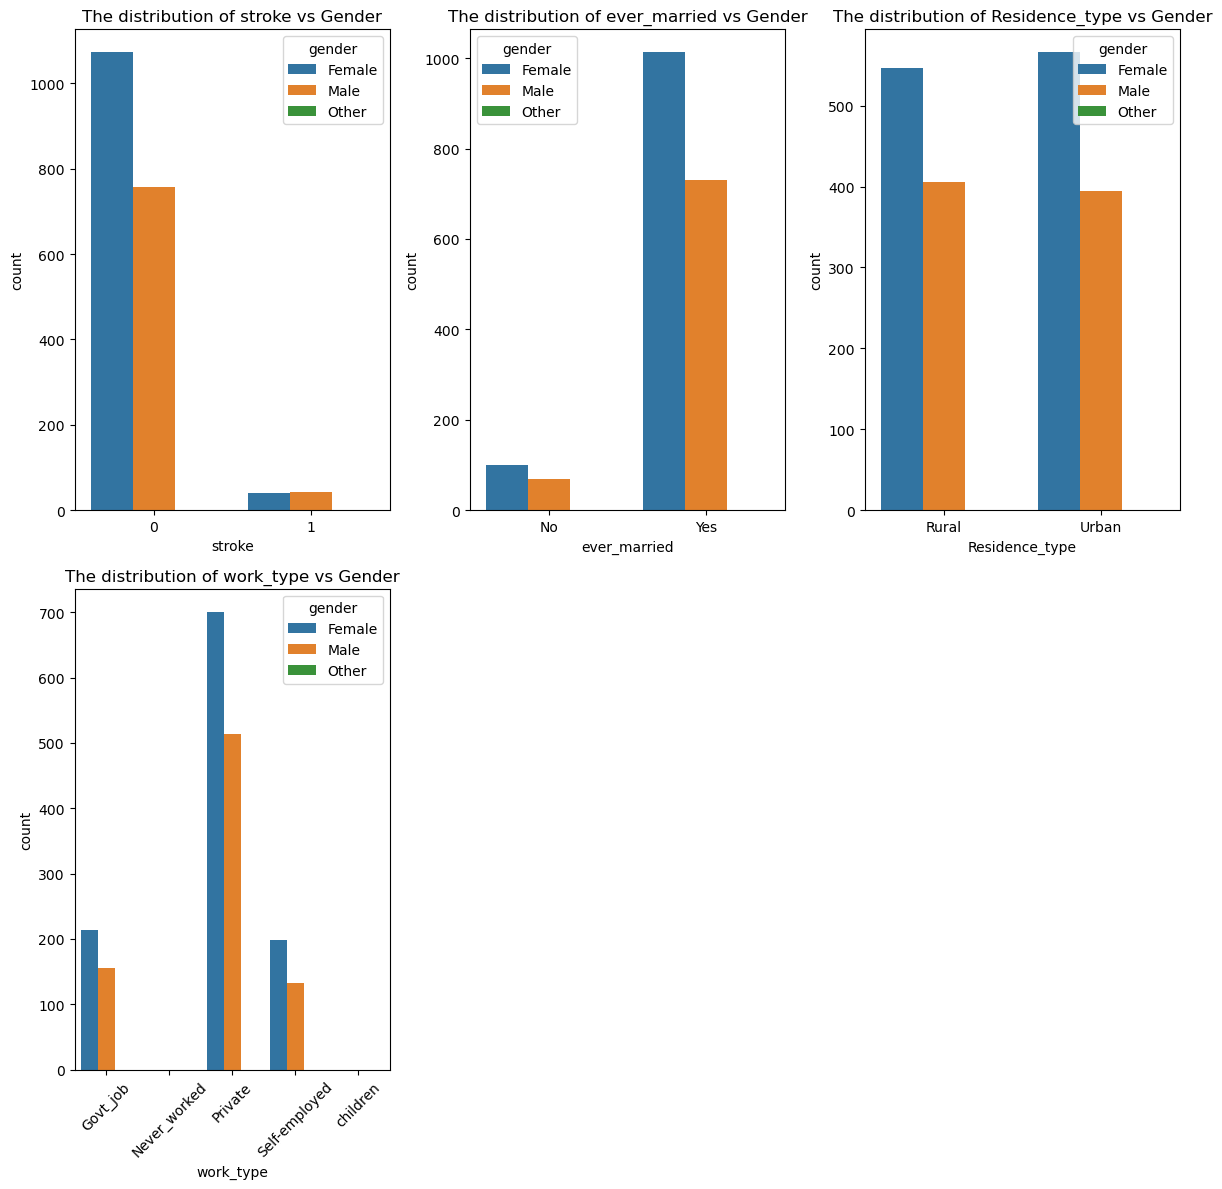

In [27]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(adult,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Middle Age

In [28]:
middleAge = data[(data['age']>=65)&(data['age']<=74)]
middleAge.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
20,Female,71.0,0,0,Yes,Govt_job,Rural,193.94,22.4,smokes,1
24,Male,71.0,0,0,Yes,Private,Urban,102.87,27.2,formerly smoked,1


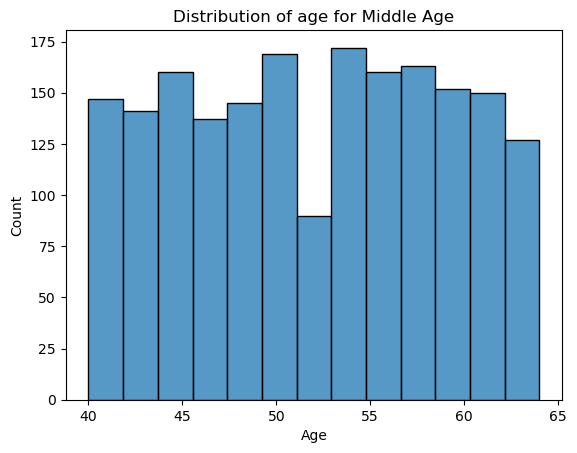

In [29]:
sns.histplot(adult, x='age')
plt.title('Distribution of age for Middle Age')
plt.xlabel('Age')
plt.show()

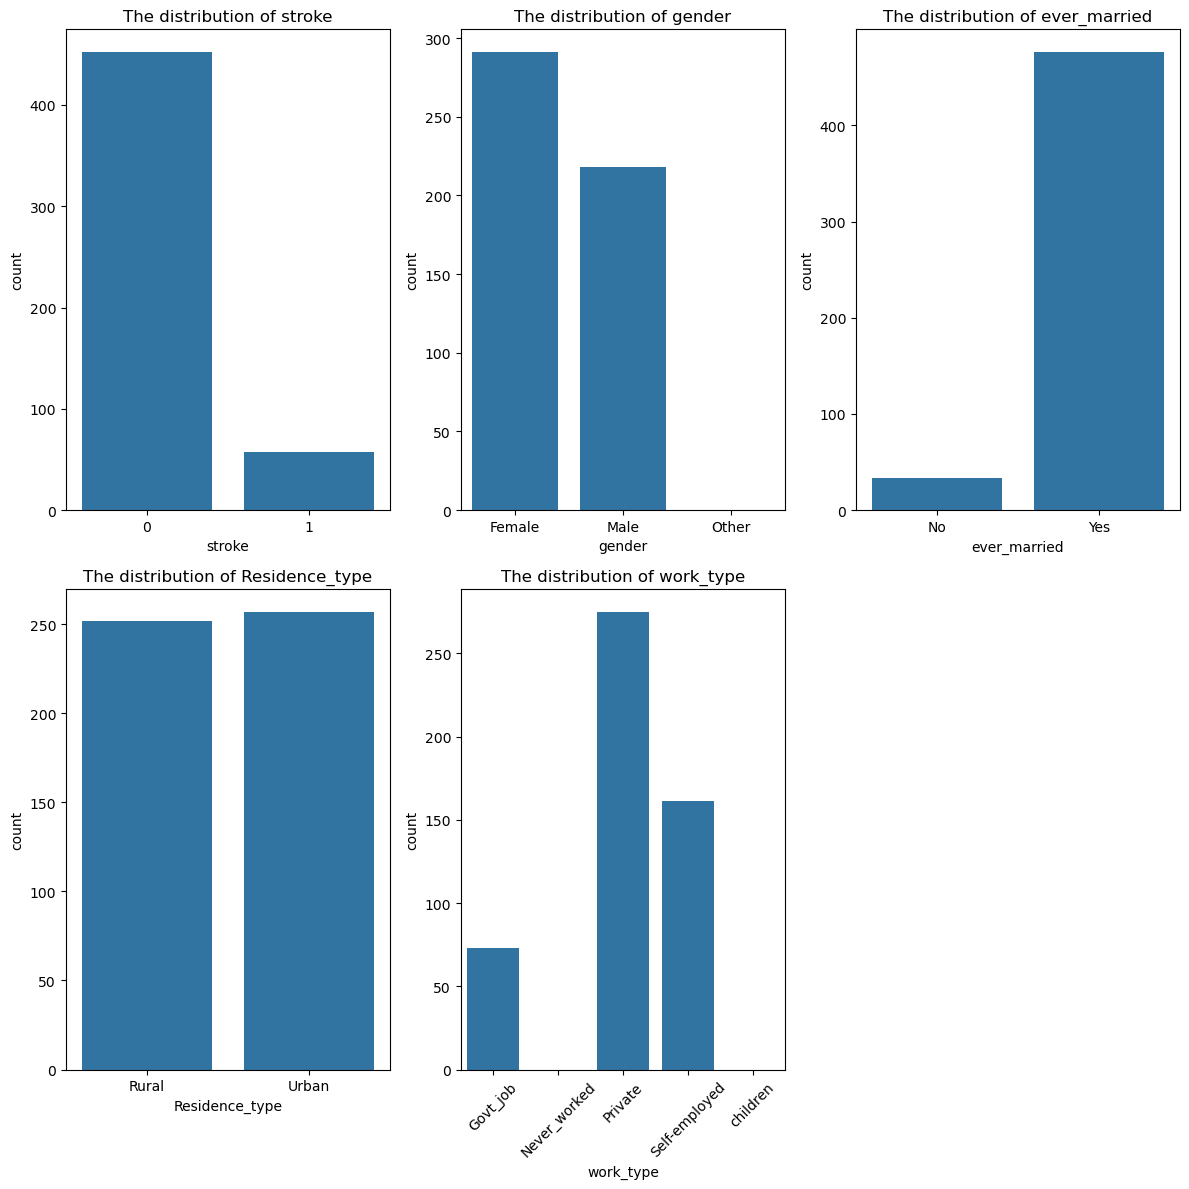

In [30]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']

for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(middleAge,x=cat,)
    plt.title(f'The distribution of {cat}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

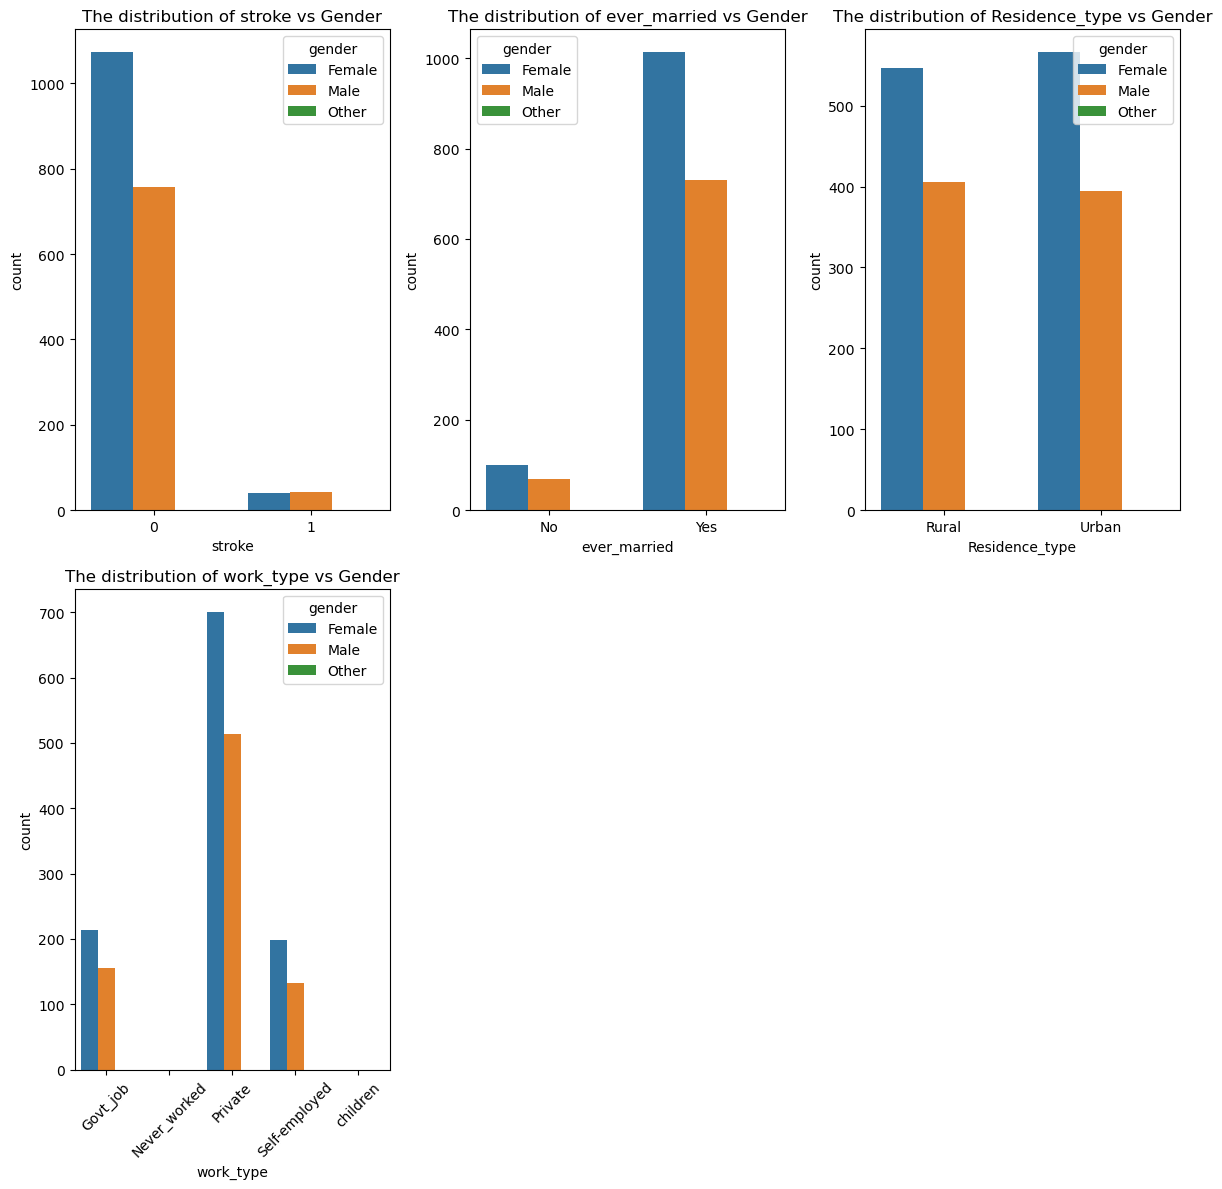

In [31]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(adult,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Older Adult

In [32]:
olderAdult = data[(data['age']>75)]
olderAdult.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1


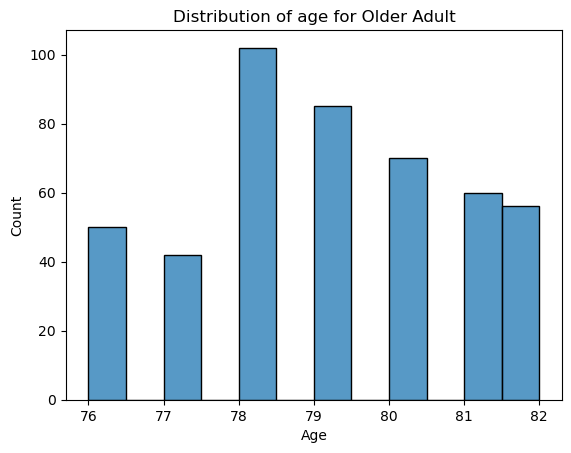

In [33]:
sns.histplot(olderAdult, x='age')
plt.title('Distribution of age for Older Adult')
plt.xlabel('Age')
plt.show()

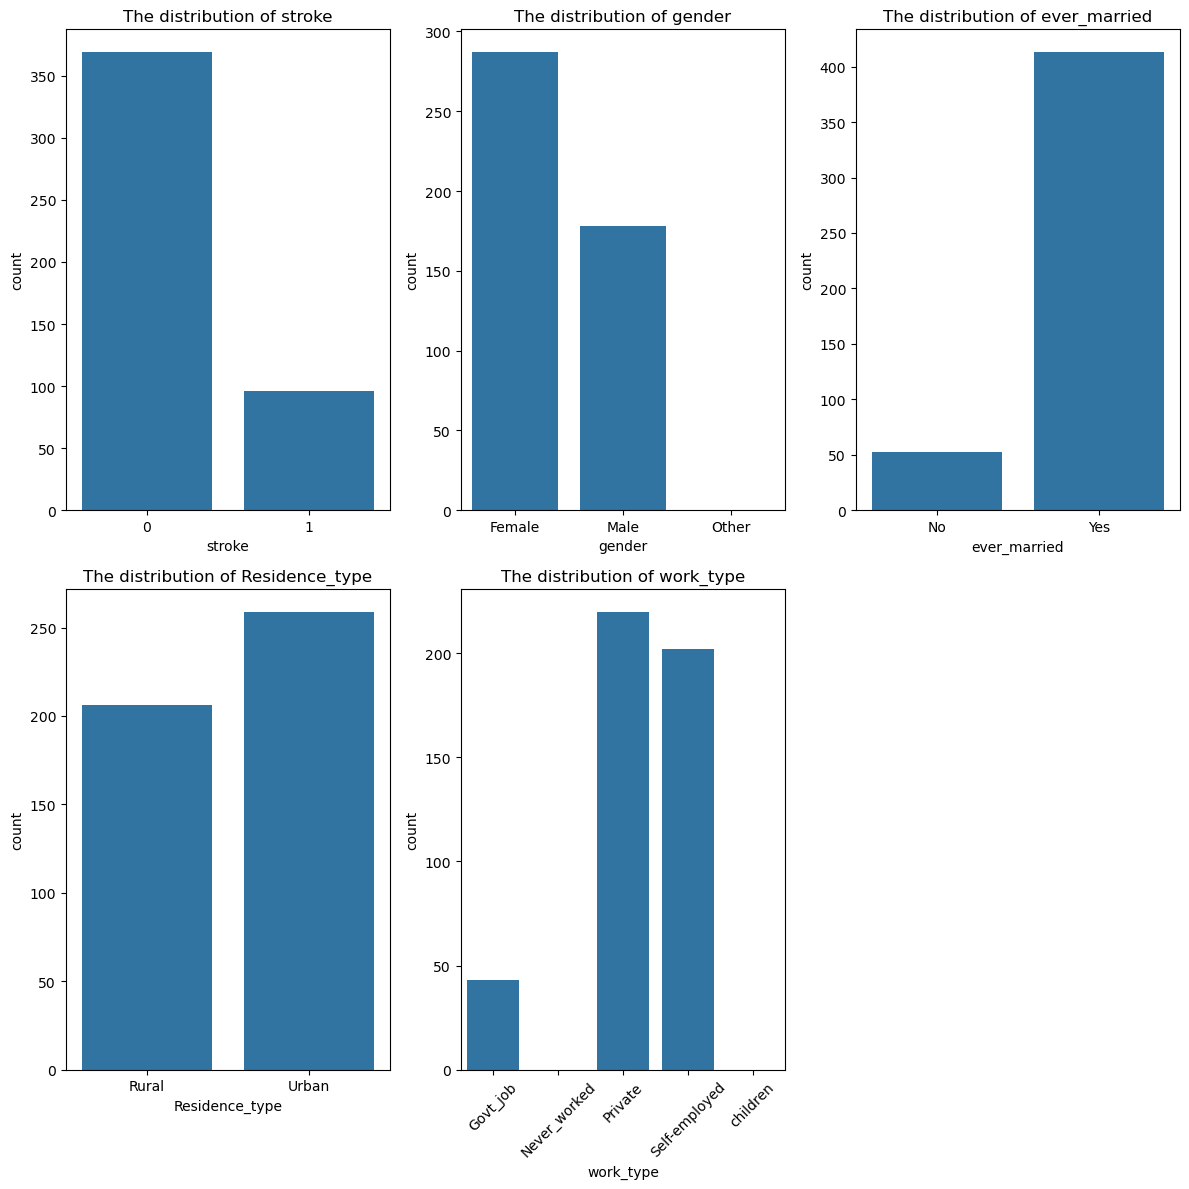

In [34]:
plt.figure(figsize=(12,12))
categories = ['stroke','gender','ever_married','Residence_type','work_type']

for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(olderAdult,x=cat,)
    plt.title(f'The distribution of {cat}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

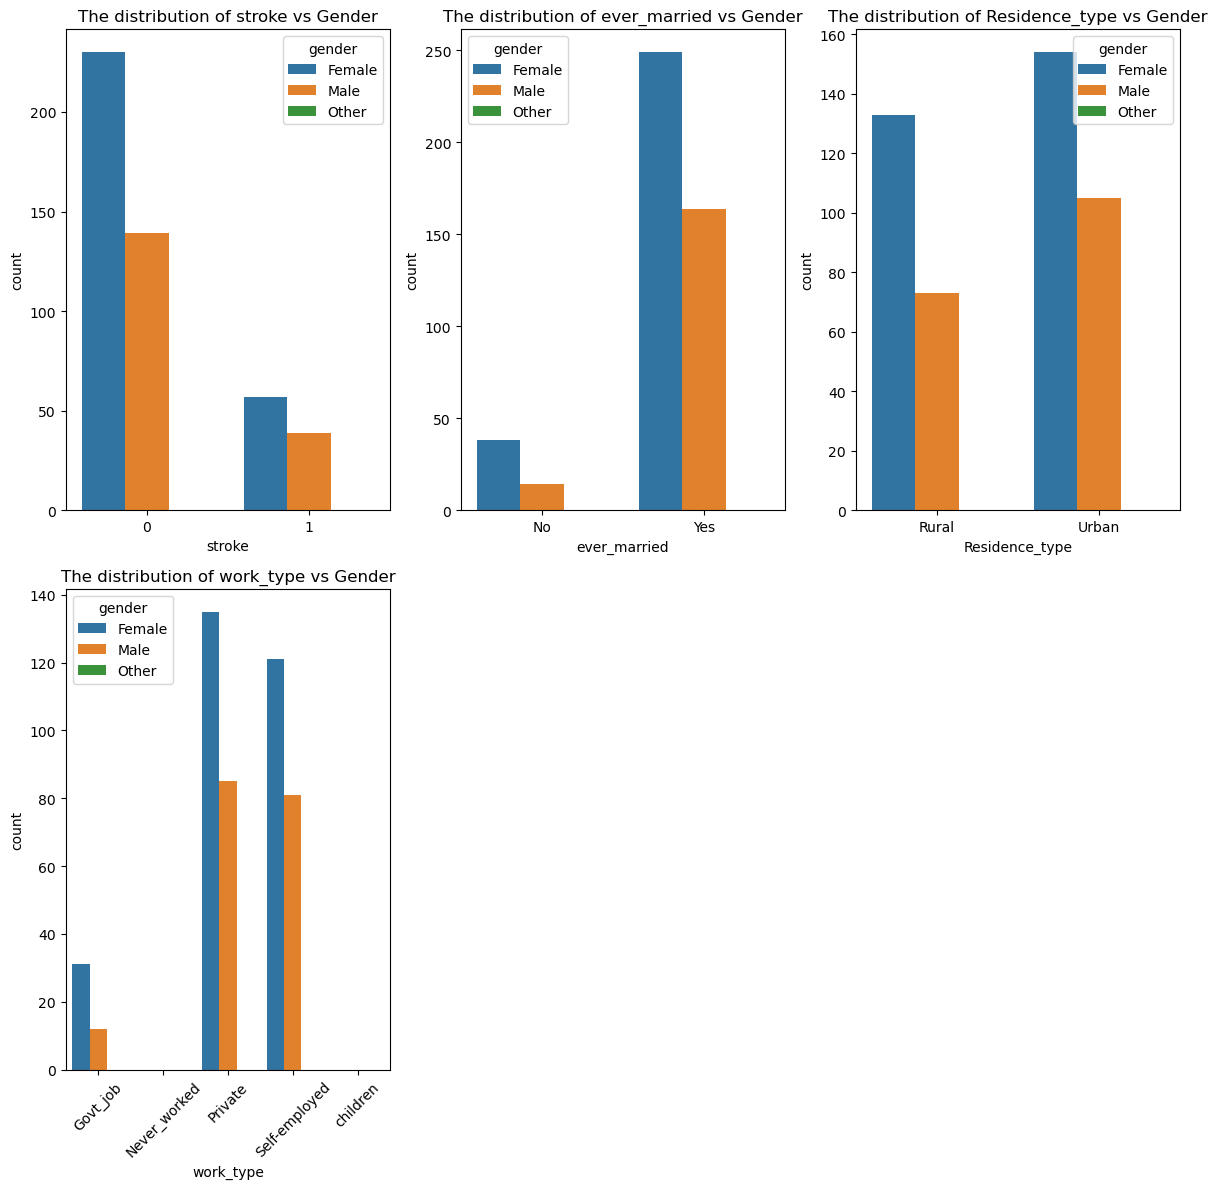

In [35]:
plt.figure(figsize=(12,12))
categories = ['stroke','ever_married','Residence_type','work_type']
for index,cat in enumerate(categories):
    plt.subplot(2,3,index+1)
    sns.countplot(olderAdult,x=cat,hue='gender')
    plt.title(f'The distribution of {cat} vs Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
1. among the older adults we have the highest level of self employment

# Correlation

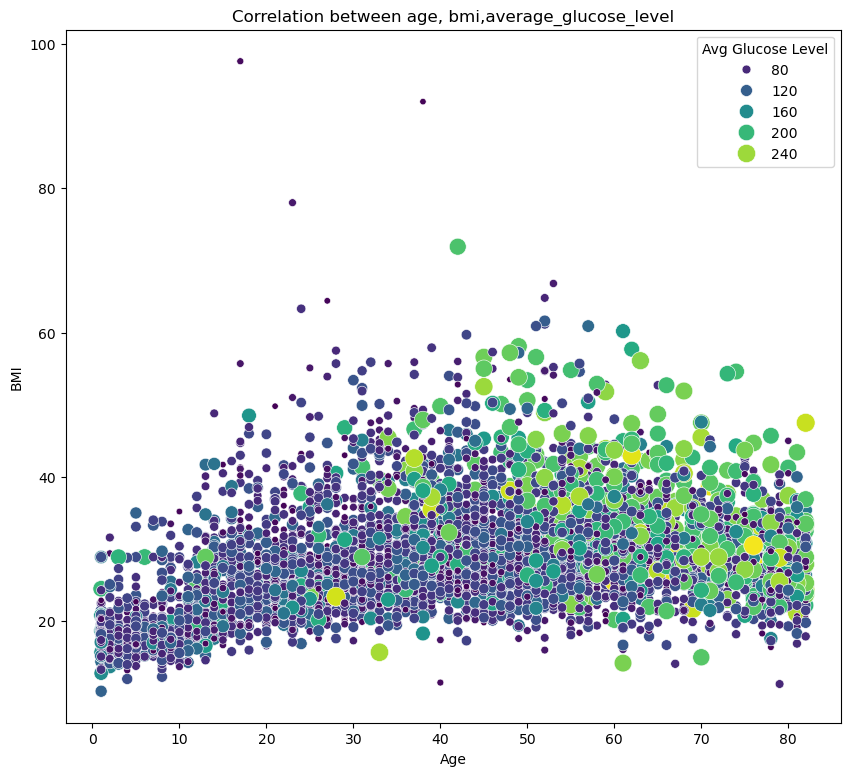

In [90]:
# correlation between numerical values

plt.figure(figsize=(10,9))
sns.scatterplot(data,x='age',size='avg_glucose_level',y='bmi',sizes=(20,200),hue='avg_glucose_level',palette='viridis')
plt.title("Correlation between age, bmi,average_glucose_level")
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(title='Avg Glucose Level')
plt.show()

1. the older the higher the glucose level
2. the younger the age the lower the glucose level


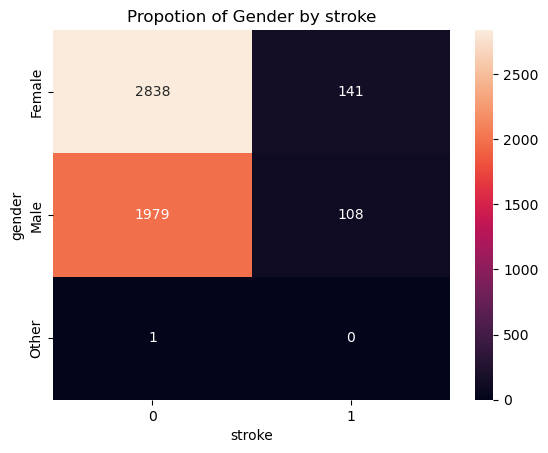

In [37]:
# correlation between categorical variables
age_stroke = pd.crosstab(data['gender'],data['stroke'])
sns.heatmap(age_stroke,annot=True,fmt='d')
plt.title('Propotion of Gender by stroke')
plt.show()


# Feature Engineering

In [38]:
### Encode the dataset
X = data.drop(columns=['stroke'],axis=1)
encoder = LabelEncoder()
categorical_features = [col for col in data.select_dtypes(include=['category']).columns if col !='stroke']
for col in categorical_features:
    if col !='stroke':
        X[col]= encoder.fit_transform(X[col])

y= pd.Series(encoder.fit_transform(data["stroke"]))

In [39]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.600000,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2
2,1,80.0,0,1,1,2,0,105.92,32.500000,2
3,0,49.0,0,0,1,2,1,171.23,34.400000,3
4,0,79.0,1,0,1,3,0,174.12,24.000000,2


In [40]:
y.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [41]:
# Feature selection using kbest.
featureSelection = SelectKBest(score_func=chi2,k=10)
X = featureSelection.fit_transform(X,y)
mask = featureSelection.get_support()
new_features={}

for bool, feature in zip(data.columns,mask):
    new_features[bool]=feature
print(new_features)

{'gender': True, 'age': True, 'hypertension': True, 'heart_disease': True, 'ever_married': True, 'work_type': True, 'Residence_type': True, 'avg_glucose_level': True, 'bmi': True, 'smoking_status': True}


In [42]:
# Total Number of female and Male with stroke

female_with_stroke= data[(data['gender']=='Female')&(data['stroke']==1)].value_counts().sum()
male_with_stroke = data[(data['gender']=='Male')&(data['stroke']==1)].value_counts().sum()
female_with_stroke, male_with_stroke

(141, 108)

In [43]:
# Total number of male and female with no stroke
female_no_stroke = data[(data['gender']=='Female')&(data['stroke']==0)].value_counts().sum()
male_no_stroke = data[(data['gender']=='Male')&(data['stroke']==0)].value_counts().sum()
female_no_stroke, male_no_stroke

(2838, 1979)

In [44]:
# Total male and female
male = data[(data['gender']=='Male')].value_counts().sum()
female = data[(data['gender']=='Female')].value_counts().sum()
male, female

(2087, 2979)

In [45]:
# Percentage of Female with stroke
female_withstroke_total = data[(data['gender']=='Female')&(data['stroke']==1)].value_counts().sum()

#total_number_of_female = data[(data['gender']=='Female')].value_counts().sum()
total_number_of_female = data.value_counts().sum()

female_percentage_withstroke = (female_withstroke_total/total_number_of_female)*100
female_percentage_withstroke

2.782711663706335

In [46]:
# Percentage of male with stroke
male_withstroke_total = data[(data['gender']=='Male')&(data['stroke']==1)].shape[0]

#total_number_of_male = data[(data['gender']=='Male')].value_counts().sum()
total_number_of_male = data.value_counts().sum()

male_percentage_withstroke = (male_withstroke_total/total_number_of_male)*100
male_percentage_withstroke

2.1314387211367674

In [47]:
# Percentage of Female with no stroke
female_withnostroke_total = data[(data['gender']=='Female')&(data['stroke']==0)].value_counts().sum()

#total_number_of_female = data[(data['gender']=='Female')].value_counts().sum()
total_number_of_female = data.value_counts().sum()

female_percentage_withnostroke = (female_withnostroke_total/total_number_of_female)*100
female_percentage_withnostroke

56.00947306098283

In [48]:
# Percentage of male with no stroke
male_withnostroke_total = data[(data['gender']=='Male')&(data['stroke']==0)].shape[0]

#total_number_of_male = data[(data['gender']=='Male')].value_counts().sum()
total_number_of_male = data.value_counts().sum()

male_percentage_withnostroke = (male_withnostroke_total/total_number_of_male)*100
male_percentage_withnostroke

39.056641010459835

In [49]:
data_frame = pd.DataFrame({'Total Male':male,'Total Female':female,'Male with Stroke':male_with_stroke,'Female with stroke':female_with_stroke,
                          'Male with no Stroke':male_no_stroke,'Female with no Stroke':female_no_stroke,'Percentage of female with stroke':female_percentage_withstroke,
                          'Percentage of male with stroke':male_percentage_withstroke,
                          'Percentage of female with no stroke':female_percentage_withnostroke,
                          'Percentage of male with no stroke':male_percentage_withnostroke},index=[0])
data_frame = data_frame.style.format({
    'Percentage of female with stroke': '{:.2f}',  # Two decimal places
    'Percentage of fmale with stroke': '{:.2f}',
    'Percentage of female with no stroke': '{:.2f}',  # Two decimal places
    'Percentage of male with no stroke': '{:.2f}',
   
})
data_frame

,Total Male,Total Female,Male with Stroke,Female with stroke,Male with no Stroke,Female with no Stroke,Percentage of female with stroke,Percentage of male with stroke,Percentage of female with no stroke,Percentage of male with no stroke
0,2087,2979,108,141,1979,2838,2.78,2.131439,56.01,39.06


# Modelling
1. RandomForest Classifier
2. LogisticRegression
3. Support Vector Machine
4. K nearest Neigbors

In [50]:
#Split dataset into train and test

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [51]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [52]:
y_pred_rfc = rfc.predict(X_test)


In [65]:
rf_accuracy_score=accuracy_score(y_pred_rfc,y_test)

For LogisticRegression, support vector machine, and KNN i will scale the data

In [54]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [55]:
lgr = LogisticRegression()
lgr.fit(X_train_scale,y_train)

LogisticRegression()

In [56]:
y_pred_lgr = lgr.predict(X_test_scale)

In [66]:
lgr_accuracy_score=accuracy_score(y_pred_lgr,y_test)

In [58]:
knn = KNeighborsClassifier()
knn.fit(X_train_scale,y_train)

KNeighborsClassifier()

In [59]:
y_pred_knn=knn.predict(X_test_scale)

In [67]:
knn_accuracy_score=accuracy_score(y_pred_knn,y_test)

In [61]:
svm= SVC()
svm.fit(X_train_scale,y_train)

SVC()

In [63]:
y_pred_svm = svm.predict(X_test_scale)

In [68]:
svm_accuracy_score=accuracy_score(y_pred_svm,y_test)

## Confusion Matrix

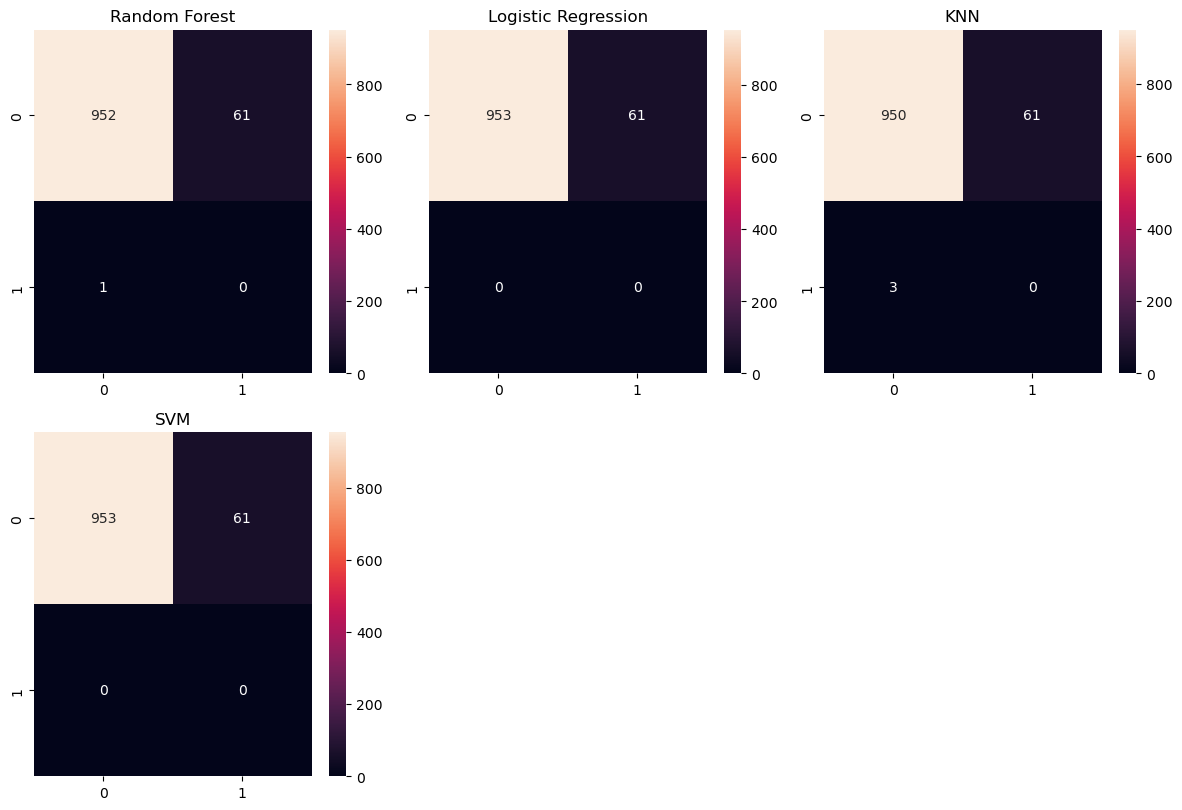

In [103]:
plt.figure(figsize=(12,12))
models = ['Random Forest','Logistic Regression','KNN','SVM']
pred_list = [y_pred_rfc,y_pred_lgr,y_pred_knn,y_pred_svm]

for index,cm in enumerate(pred_list):
    matrix=confusion_matrix(cm,y_test)
    plt.subplot(3,3,index+1)
    sns.heatmap(matrix,annot=True,fmt='d')
    plt.title(f'{[model for model in models][index]}')
plt.tight_layout()
plt.show()


## Visualize the accuracy of each model using bargraph

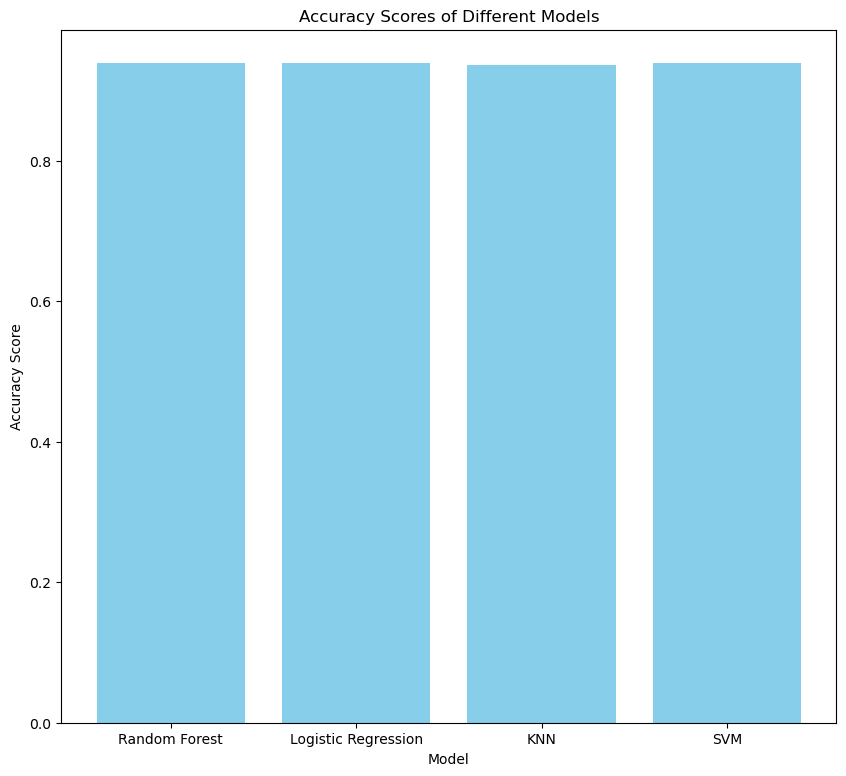

In [74]:

models = ['Random Forest','Logistic Regression', 'KNN','SVM']
accuracy_scores = [rf_accuracy_score, lgr_accuracy_score, knn_accuracy_score, svm_accuracy_score]
plt.figure(figsize=(10,9))
for m,a in zip(models,accuracy_scores):
    
    plt.bar(m,a,color='skyblue')
    # Adding titles and labels
    plt.title('Accuracy Scores of Different Models')
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score')

# Show the plot
plt.show()

In [115]:
# check for overfitting by ploting a learning curve

model_name = ['Random Forest','Logistic Regression', 'KNN','SVM']
import warnings
warnings.filterwarnings('ignore')
def learningCurve(model):
   
    train_sizes,train_score,test_score = learning_curve(model,X,y,cv=5,train_sizes=np.linspace(0.1,1.0,10),scoring='accuracy')
    train_score_mean = np.mean(train_score,axis=1)
    test_score_mean = np.mean(test_score,axis=1)
    plt.plot(train_sizes, train_score_mean, label="Training score")
    plt.plot(train_sizes, test_score_mean, label="Test score")
    plt.legend()
    plt.xlabel("Training set size")
    plt.ylabel("Accuracy score")
    plt.show()

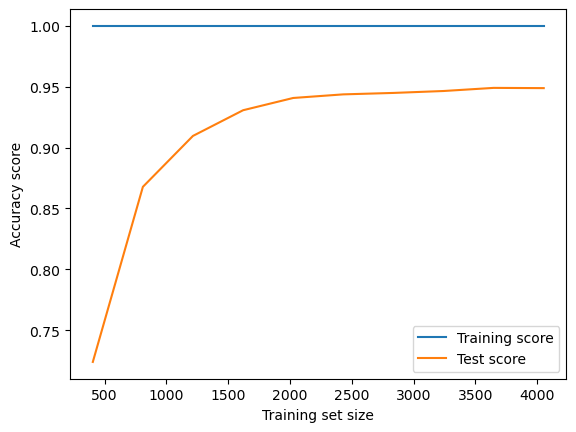

In [116]:
learningCurve(rfc)

the training score is higer than the test score which indicates overfitting

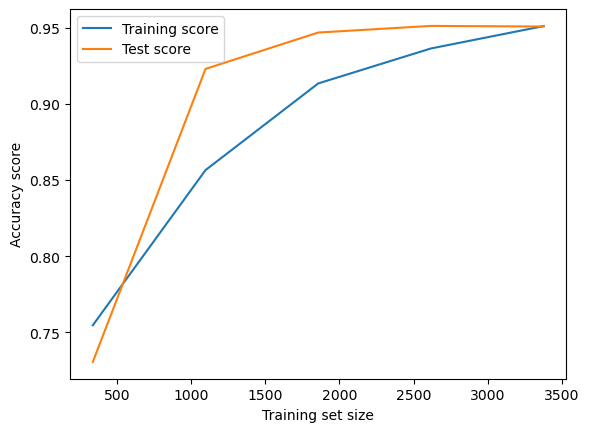

In [82]:
learningCurve(lgr)

The test score is higher than the training score which implies no overfitting the model is performing well

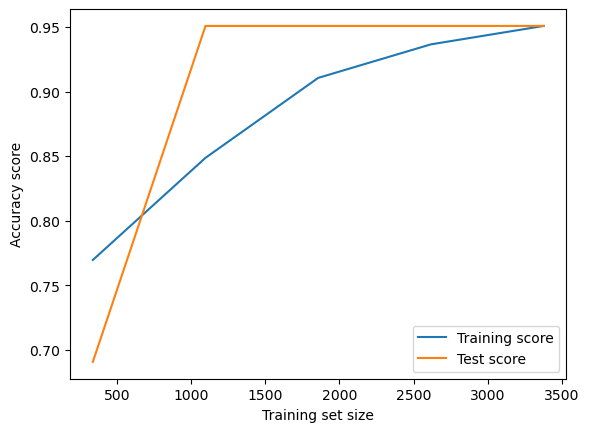

In [83]:
learningCurve(svm)

The test score is higher than the training score which implies no overfitting the model is performing well


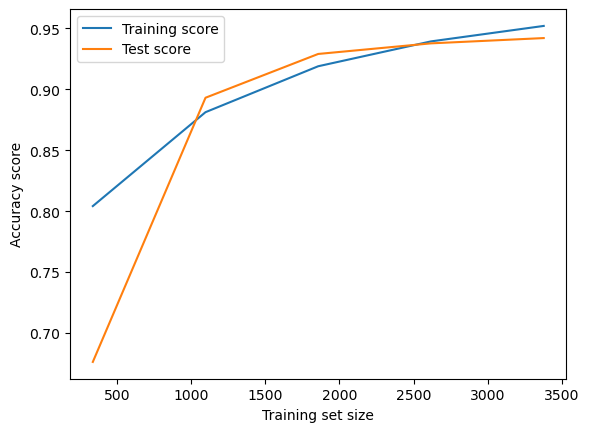

In [85]:
learningCurve(knn)

the curve indicates a little amount of overfitting

i will choose the Logistic Regression model
1. it is fast and simple for binary classification problem
2. the model is able to generalize well
3. it is resource less intensive